# Data Collection and Cleaning

Using the r/changemyview community on reddit, we will collect data on the posts and comments in the community. We will then clean the data to ensure that it is in a format that can be used for analysis. 

The data will be collected in JSON format. Each post consists of a post (OP) and comments as a list of dictionaries. Comments that are chosen to be the best comment will be marked as a delta given the `delta: true` attribute.

In [8]:
# Download the data
# !curl -O https://the-eye.eu/redarcs/files/changemyview_submissions.zst
# !curl -O https://the-eye.eu/redarcs/files/changemyview_comments.zst


In [9]:
# Uncompress the data
# !unzstd changemyview_submissions.zst
# !unzstd changemyview_comments.zst

In [10]:
import json
from datetime import datetime

# Paths to the decompressed files
submissions_file = 'changemyview_submissions'
comments_file = 'changemyview_comments'

# Define the date range for filtering
start_date = datetime(2021, 10, 1)
end_date = datetime(2024, 5, 26)

# Function to check if a date is within the specified range
def is_within_date_range(timestamp):
    date = datetime.fromtimestamp(int(timestamp))
    return start_date <= date <= end_date

# Load submissions and filter for those within the date range and with "Delta(s) from OP"
with open(submissions_file, 'r') as f:
    submissions = [json.loads(line) for line in f if is_within_date_range(json.loads(line)['created_utc']) and json.loads(line).get('link_flair_text') == "Delta(s) from OP"]

# Create a dictionary to store comments associated with each submission
posts = {submission['id']: {'post': submission, 'comments': []} for submission in submissions}

# Load comments and associate with the corresponding submission
with open(comments_file, 'r') as f:
    for line in f:
        comment = json.loads(line)
        if is_within_date_range(comment['created_utc']) and comment['link_id'][3:] in posts:
            posts[comment['link_id'][3:]]['comments'].append(comment)

# Identify delta comments and mark parent comments
for post in posts.values():
    comments_dict = {comment['id']: comment for comment in post['comments']}
    for comment in post['comments']:
        if '!delta' in comment['body']:
            parent_id = comment.get('parent_id', '').split('_')[-1]
            if parent_id in comments_dict:
                comments_dict[parent_id]['delta'] = "true"

    # Mark all comments as "delta": "false" by default if not already marked
    for comment in post['comments']:
        if 'delta' not in comment:
            comment['delta'] = "false"

# save
posts_list = list(posts.values())

with open('filtered_posts_with_deltas_october_2021_to_may_2024.json', 'w') as f:
    json.dump(posts_list, f, indent=2)


Turn the data into two dataframes for the posts and comments.

In [17]:
import pandas as pd

# Load the JSON file
input_file = 'filtered_posts_with_deltas_october_2021_to_may_2024.json'

with open(input_file, 'r') as f:
    posts_list = json.load(f)

# Create a DataFrame for comments
comments_data = []
posts_data = []
for post in posts_list:
    post_data = post['post'].copy()
    post_data['post_id'] = post['post']['id']  # Add post_id to associate comments with posts
    posts_data.append(post_data)
    for comment in post['comments']:
        comment_data = comment.copy()
        comment_data['post_id'] = post['post']['id']  # Add post_id to associate comments with posts
        comments_data.append(comment_data)

comments_df = pd.DataFrame(comments_data)
posts_df = pd.DataFrame(posts_data)

# Display the first few rows of each DataFrame
print("Posts DataFrame:")
print(posts_df.head())
print("\nComments DataFrame:")
print(comments_df.head())


Posts DataFrame:
                                       all_awardings  allow_live_comments  \
0                                                 []                False   
1                                                 []                False   
2                                                 []                False   
3  [{'award_sub_type': 'GLOBAL', 'award_type': 'g...                 True   
4                                                 []                False   

   archived            author  author_created_utc  \
0      True     pepe_extendus        1.532210e+09   
1      True         [deleted]                 NaN   
2      True        DiscussTek        1.539197e+09   
3      True  i_havent_read_it        1.306668e+09   
4      True   twinfiresigns14        1.608777e+09   

  author_flair_background_color author_flair_css_class author_flair_richtext  \
0                          None                   None                    []   
1                                        

In [16]:
posts_df.to_csv('posts.csv')
comments_df.to_csv('comments.csv')

Test the data

In [18]:
# Load the CSV files
posts_df = pd.read_csv('posts.csv', index_col=0)
comments_df = pd.read_csv('comments.csv', index_col=0)

# only keep the post_id column, delta, and body columns for comments
comments_df = comments_df[['post_id', 'delta', 'body']]
# show the head
print(comments_df.head())

/var/folders/vm/6_sk059d25x7g6b8w6f1_vc40000gn/T/ipykernel_68877/1653902233.py:3: DtypeWarning: Columns (0,12,13,14,17,18,19,25,27,29,32,34,35,36,45,53) have mixed types. Specify dtype option on import or set low_memory=False.
  comments_df = pd.read_csv('comments.csv', index_col=0)


  post_id  delta                                               body
0  pz0w6x  False                                          [deleted]
1  pz0w6x  False  The biggest problem with two spaces is that it...
2  pz0w6x  False  Do you think your post is difficult to disging...
3  pz0w6x  False  That is a very good point, I have had troubles...
4  pz0w6x  False  /u/pepe_extendus (OP) has awarded 3 delta(s) i...


In [21]:
comments_df[comments_df['delta'] == True]

,post_id,delta,body
9,pz0w6x,True,One of the final steps on preparing a document...
166,pz2hp9,True,The classes were not necessarily meant to teac...
192,pz2hp9,True,College and education does not exist to make y...
228,pzri5s,True,It's telling me that the problem is my body an...
236,pzri5s,True,I'm assuming this is in relation to Sarah Ever...
...,...,...,...
911759,1003si2,True,So I guess I'm struggling with the issue here....
911760,1003si2,True,I mean based on that last paragraph you’re def...
911768,1003si2,True,"Agreed, but I think you’ll find more in common..."
911808,1003si2,True,"As far as student loans, we don't have great a..."


Remove data points with [removed] or [deleted] in the body of the comments. Clean the dataset

In [25]:
import numpy as np

# remove data points with [removed] or [deleted] in the body of the comments
comments_df = comments_df[~comments_df['body'].isin(['[removed]', '[deleted]'])]

# remove Nan
comments_df = comments_df.dropna()

comments = comments_df.to_numpy()

# save the comments
np.save('comments.npy', comments)

In [31]:
comments[:,-1]
# should have type string for all of the body column

"The biggest problem with two spaces is that it makes editing more difficult. If you want to rearrange a sentence structure to split one sentence into two, or combine two sentences, now you need to worry about where you are adding or removing spaces. This is especially prone to error when you're clicking between two sentences, and now your cursor might end up in between the two spaces. So if you're doing extensive editing on a document with double-spaces between sentences, you're likely to need to put a significant amount of effort into checking it, and you're more prone to inconsistencies.\n\nThat difference doesn't matter on a typewriter, because you don't do that sort of editing, but matters a lot in word processing software.\n\nI have some anecdotal evidence to back this up. At a school I previously taught at, teachers regularly wrote letters and had another teacher proofread them before they went out. When I was editing letters from people who habitually used single spaces, there 

# Score the assertiveness of comments using Pei's Model

Using the SciBert Pei's model, we will score the sentence level assertiveness of the comments.

In [ ]:
!pip install numpy==1.26.3
!pip install transformers
!pip install certainty_estimator
# use Cuda if available

# CUDA = torch.cuda.is_available()

import numpy as np
import pandas as pd
from certainty_estimator import CertaintyEstimator
from tqdm import tqdm

estimator = CertaintyEstimator('sentence-level', cuda=True)

# Load the comments
cm_df = pd.read_csv('comments.csv', dtype={'body': str}, index_col=0)

comments = cm_df.to_numpy()

comments[2] = comments[2].astype(str)

bodies = comments[:,-1]

# Estimate the certainty of the comments
certainty_scores = estimator.predict(bodies, tqdm=tqdm)

# Add the certainty scores to the comments array
comments_with_certainty = np.hstack((comments, certainty_scores.reshape(-1, 1)))

# Save the comments with certainty scores
np.save('comments_with_certainty.npy', comments_with_certainty)


# Analyze the assertivity of the scored comments

Load the data and do a final clean up for the irrelevant columns and data points (those with unrelated comments to the delta system)

In [7]:
import numpy as np
import pandas as pd
comments_array = np.load('comments_with_certainty.npy', allow_pickle=True)

columns = ['post_id', 'delta', 'body', 'assertivity']
comments_df = pd.DataFrame(comments_array, columns=columns)
comments_df

,post_id,delta,body,assertivity
0,pz0w6x,False,The biggest problem with two spaces is that it...,4.303459
1,pz0w6x,False,Do you think your post is difficult to disging...,4.838442
2,pz0w6x,False,"That is a very good point, I have had troubles...",4.822953
3,pz0w6x,False,/u/pepe_extendus (OP) has awarded 3 delta(s) i...,5.036173
4,pz0w6x,False,Confirmed: 1 delta awarded to /u/Salanmander (...,5.059403
...,...,...,...,...
850130,1005v09,False,"No, public universities are part of the state....",5.173915
850131,1005v09,False,"&gt;And again, Hooters waitresses wear tank to...",5.074471
850132,1005v09,False,[Here's the full court decision explaining why...,5.04283
850133,1005v09,False,&gt; If Republicans want to restrict what prof...,4.463691


In [8]:

# remove posts with body '(OP) has awarded' in them 
comments_df = comments_df[~comments_df['body'].str.contains(r'\(OP\) has awarded', na=False)]
# remove posts with body 'delta awarded' in them
comments_df = comments_df[~comments_df['body'].str.contains(r'delta awarded', na=False)]
# Ensure the 'delta' column is boolean
comments_df['delta'] = comments_df['delta'].astype(bool)

# Filter groups where at least one 'delta' is True
filtered_df = comments_df.groupby('post_id').filter(lambda x: x['delta'].any())

# just keep post id delta and assertivity
filtered_df = filtered_df[['post_id', 'delta', 'assertivity']]

filtered_df



,post_id,delta,assertivity
0,pz0w6x,False,4.303459
1,pz0w6x,False,4.838442
2,pz0w6x,True,4.822953
5,pz0w6x,False,4.462715
6,pz0w6x,False,4.165082
...,...,...,...
850121,1003si2,False,4.543573
850122,1003si2,False,4.63549
850123,1003si2,False,4.942189
850124,1003si2,False,4.601137


Group the data by the post to which they relate and rank the comments by their assertiveness score in the group.

In [12]:
# Group the data by the post to which they relate and rank the comments by their assertiveness score in the group and add a column rank_in_group
filtered_df['rank_in_group'] = filtered_df.groupby('post_id')['assertivity'].rank(ascending=False)

# Display the first few rows of the DataFrame
filtered_df[filtered_df['post_id'] == 'pz0w6x']
df = filtered_df


In [14]:
df

,post_id,delta,assertivity,rank_in_group
0,pz0w6x,False,4.303459,34.0
1,pz0w6x,False,4.838442,20.0
2,pz0w6x,True,4.822953,21.0
5,pz0w6x,False,4.462715,30.0
6,pz0w6x,False,4.165082,38.0
...,...,...,...,...
850121,1003si2,False,4.543573,55.0
850122,1003si2,False,4.63549,49.0
850123,1003si2,False,4.942189,16.0
850124,1003si2,False,4.601137,50.0


The num of gropups is 3150


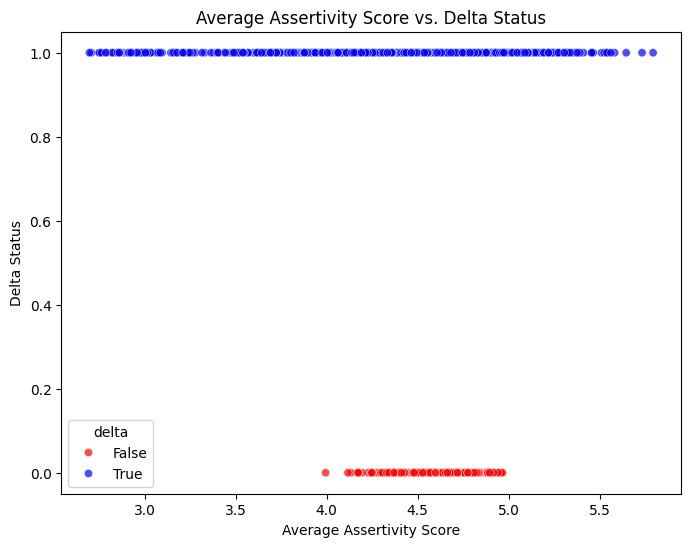

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your dataset is stored in a DataFrame called 'df'

# Group the data by post_id
grouped = df.groupby('post_id')

# Initialize lists to store data for plotting
x_true = []
y_true = []
x_false = []
y_false = []

print(f'The num of gropups is {len(grouped)}')

# Iterate over each group
for name, group in grouped:
    # Calculate average assertivity score for comments with delta True
    avg_true = group[group['delta']]['assertivity'].mean()
    # Calculate average assertivity score for comments with delta False
    avg_false = group[~group['delta']]['assertivity'].mean()
    
    # Append data points to lists
    x_true.append(avg_true)
    y_true.append(True)
    x_false.append(avg_false)
    y_false.append(False)

# Create DataFrame for plotting
plot_df = pd.DataFrame({'assertivity': x_true + x_false, 'delta': y_true + y_false})

# Plot the data using Seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(data=plot_df, x='assertivity', y='delta', hue='delta', palette={True: 'blue', False: 'red'}, alpha=0.7)
plt.xlabel('Average Assertivity Score')
plt.ylabel('Delta Status')
plt.title('Average Assertivity Score vs. Delta Status')
plt.show()


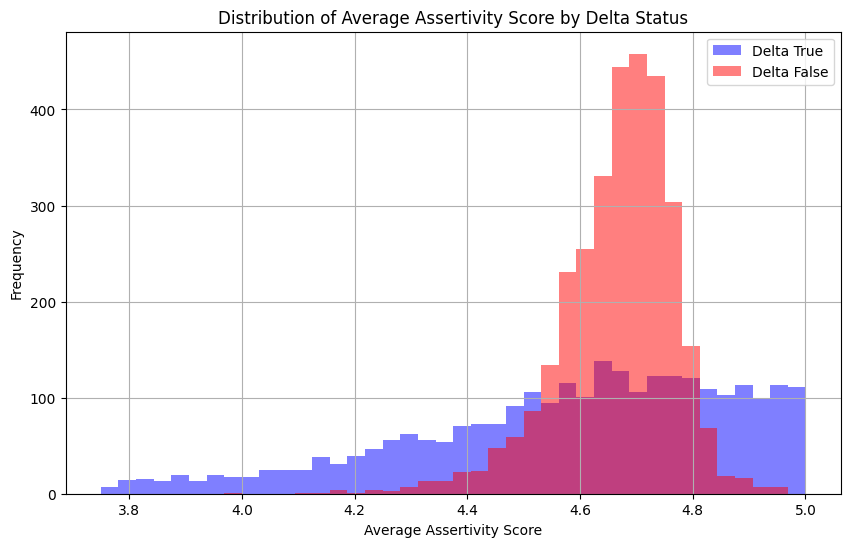

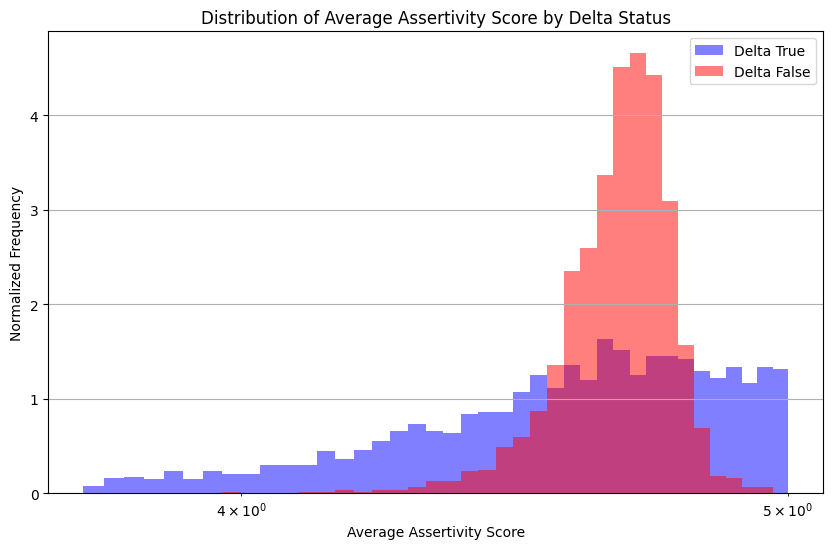

In [26]:
import numpy as np

# Define the number of bins and the range for the histogram
num_bins = 40
score_range = (3.75, 5)

# Calculate bin edges
bin_edges = np.linspace(score_range[0], score_range[1], num_bins + 1)

# Initialize lists to store histogram data
hist_true = []
hist_false = []

# Iterate over each group
for name, group in grouped:
    # Calculate average assertivity score for comments with delta True
    avg_true = group[group['delta']]['assertivity'].mean()
    # Calculate average assertivity score for comments with delta False
    avg_false = group[~group['delta']]['assertivity'].mean()
    
    # Append data points to histogram lists
    hist_true.append(avg_true)
    hist_false.append(avg_false)

# Plot the histograms
plt.figure(figsize=(10, 6))

# Histogram for delta True
plt.hist(hist_true, bins=bin_edges, alpha=0.5, color='blue', label='Delta True')

# Histogram for delta False
plt.hist(hist_false, bins=bin_edges, alpha=0.5, color='red', label='Delta False')

plt.xlabel('Average Assertivity Score')
plt.ylabel('Frequency')
plt.title('Distribution of Average Assertivity Score by Delta Status')
plt.legend()
plt.grid(True)
plt.show()




In [27]:
# Calculate overall average assertivity score for comments with delta True
overall_avg_true = df[df['delta']]['assertivity'].mean()

# Calculate overall average assertivity score for comments with delta False
overall_avg_false = df[~df['delta']]['assertivity'].mean()

print(f"Overall Average Assertivity Score for Delta True: {overall_avg_true}")
print(f"Overall Average Assertivity Score for Delta False: {overall_avg_false}")


Overall Average Assertivity Score for Delta True: 4.568338090512978
Overall Average Assertivity Score for Delta False: 4.70196553325341
